<a href="https://colab.research.google.com/github/hanarifdahs/SKC-Phishing-detection/blob/main/Phishing_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import Libraries

In [ ]:
from fastai.tabular import *
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np

import os
import sys
import glob

from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.utils.multiclass import unique_labels

This line is used to upload the dataset to the Google Collaboratory 

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Phishing.csv to Phishing.csv


Load dataset as Pandas Dataframe

In [ ]:
import io
df = pd.read_csv(io.BytesIO(uploaded['Phishing.csv']),low_memory=False)

 Checking the dimension of the dataset

In [ ]:
df.shape

(15367, 80)

Checking all the attributes used as a feature for classification

In [ ]:
df.columns

Index(['Querylength', 'domain_token_count', 'path_token_count',
       'avgdomaintokenlen', 'longdomaintokenlen', 'avgpathtokenlen', 'tld',
       'charcompvowels', 'charcompace', 'ldl_url', 'ldl_domain', 'ldl_path',
       'ldl_filename', 'ldl_getArg', 'dld_url', 'dld_domain', 'dld_path',
       'dld_filename', 'dld_getArg', 'urlLen', 'domainlength', 'pathLength',
       'subDirLen', 'fileNameLen', 'this.fileExtLen', 'ArgLen', 'pathurlRatio',
       'ArgUrlRatio', 'argDomanRatio', 'domainUrlRatio', 'pathDomainRatio',
       'argPathRatio', 'executable', 'isPortEighty', 'NumberofDotsinURL',
       'ISIpAddressInDomainName', 'CharacterContinuityRate',
       'LongestVariableValue', 'URL_DigitCount', 'host_DigitCount',
       'Directory_DigitCount', 'File_name_DigitCount', 'Extension_DigitCount',
       'Query_DigitCount', 'URL_Letter_Count', 'host_letter_count',
       'Directory_LetterCount', 'Filename_LetterCount',
       'Extension_LetterCount', 'Query_LetterCount', 'LongestPathToken

Checking the datatypes of each columns

In [1]:
df.dtypes

NameError: ignored

Display all the rows dan columns

In [ ]:
pd.options.display.max_columns = None
pd.options.display.max_rows = None

Change argPathRation data type to float

In [ ]:
df['argPathRatio'] = df['argPathRatio'].astype('float')

class distribution for original data

In [ ]:
print(df.groupby('URL_Type_obf_Type').size())

URL_Type_obf_Type
benign      7781
phishing    7586
dtype: int64


sample distribution print in markdown table format

In [ ]:
label = 'URL_Type_obf_Type'
lblTypes = set(df[label])
for lbl in lblTypes:
    print('| {} | {} |'.format(lbl, len(df[df[label] == lbl].index)))

| benign | 7781 |
| phishing | 7586 |


function loads, cleans and returns panda dataframe

In [ ]:
def loadAndCleanData(csvFile):
    pickleDump = '{}.pickle'.format(csvFile)
    if os.path.exists(pickleDump):
        df = pd.read_pickle(pickleDump)
    else:
        df = pd.read_csv(csvFile, low_memory=False)
        # clean data
        # strip the whitspaces from column names
        df = df.rename(str.strip, axis='columns')
        #df.drop(columns=[], inplace=True)
        # drop missing values/NaN etc.
        #df.dropna(inplace=True)
        # drop Infinity rows and NaN string from each column
        for col in df.columns:
            indexNames = df[df[col] == 'Infinity'].index
            if not indexNames.empty:
                print('deleting {} rows with Infinity in column {}'.format(len(indexNames), col))
                df.drop(indexNames, inplace=True)
            indexNames = df[df[col]== 'NaN'].index
            if not indexNames.empty:
                print('deleting {} rows with NaN in column {}'.format(len(indexNames), col))
                df.drop(indexNames, inplace=True)
        df['argPathRatio'].astype('float')
        # drop NaN pandas way
        beforeRows = df.shape[0]
        df.dropna(inplace = True)
        print('Dropped {} rows with NaN values'.format(beforeRows - df.shape[0]))
        df.to_pickle(pickleDump)
        
    return df

In [ ]:
df1 = loadAndCleanData('Phishing.csv')

Dropped 8644 rows with NaN values


Sample distribution print in markdown table format

In [ ]:
label = 'URL_Type_obf_Type'
lblTypes = set(df1[label])
for lbl in lblTypes:
    print('| {} | {} |'.format(lbl, len(df1[df1[label] == lbl].index)))

| benign | 2709 |
| phishing | 4014 |


Histograms of each attribute

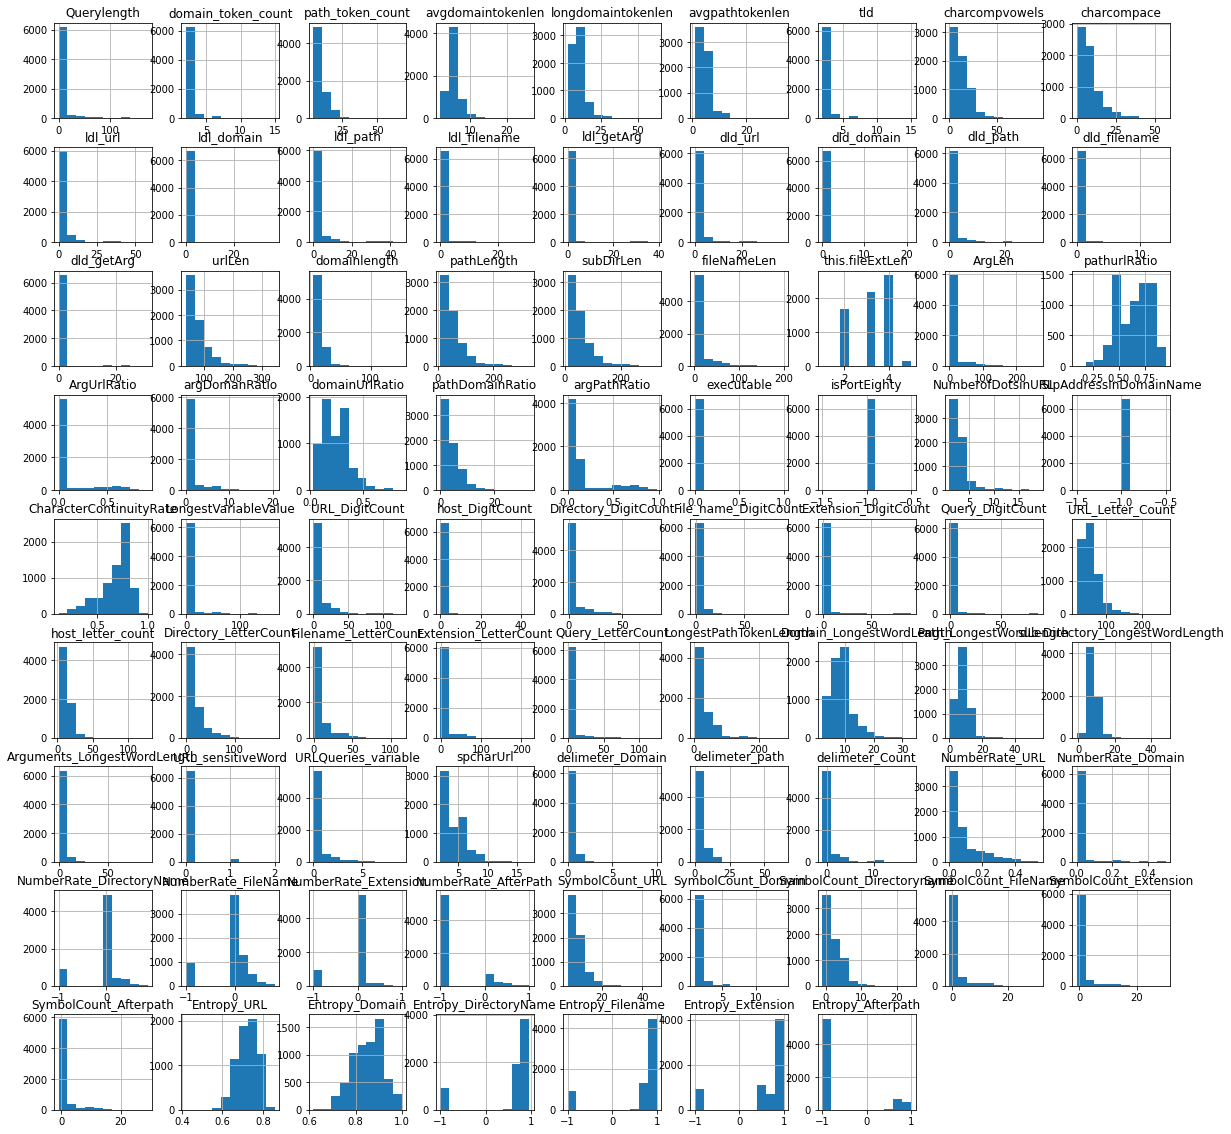

In [ ]:
df1.hist(figsize=(20, 20))
#plt.figure(figsize=(2, 1))
#plt.show()

Split-out validation dataset

In [ ]:
def splitDataset(df):
    array = df.values
    # Splitting based on the all 79 features
    X = array[:,0:79]
    Y = array[:,79]
    validation_size = 0.25
    random_seed = 100
    X_train, X_validation, Y_train, Y_validation = model_selection.train_test_split(X, Y, 
                                                                                    test_size=validation_size, 
                                                                                    random_state=random_seed)
    return X_train, X_validation, Y_train, Y_validation

Running the main experiments on testing the models

---


Models used are Decision Tree and Random Forest

In [ ]:
def runExperiments(X_train, Y_train):
    random_seed = 100
    scoring = 'accuracy'
    models = []
    models.append(('DT', DecisionTreeClassifier()))
    models.append(('RF', RandomForestClassifier(n_estimators=10)))
    # evaluate each model in turn using 10-fold cross-validation
    results = []
    classifiers = []
    accuracies = []
    for classifier, model in models:
        kfold = model_selection.KFold(n_splits=10, random_state=random_seed)
        cv_results = model_selection.cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
        accuracies.append((cv_results.mean(), classifier))
        results.append(cv_results)
        classifiers.append(classifier)
        msg = "%s: %f (%f)" % (classifier, cv_results.mean(), cv_results.std())
        print(msg)
    return results, accuracies, classifiers

In [ ]:
X_train, X_validation, Y_train, Y_validation = splitDataset(df1)
results, accuracies, classifiers = runExperiments(X_train, Y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


DT: 0.963904 (0.006502)


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


RF: 0.972435 (0.005549)


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


AB: 0.970051 (0.006956)


In [ ]:
def compareModels(accuracies, results, classifiers):
    # sort the mean accuracy results in descending order and print
    accuracies.sort(reverse=True)
    for acc, cls in accuracies:
        print("{} {:.2f}".format(cls, acc))
    # Compare Algorithms using box-plot
    fig = plt.figure(figsize=(8, 6))
    fig.suptitle('Algorithm Comparison')
    ax = fig.add_subplot(111)
    plt.boxplot(results)
    ax.set_xticklabels(classifiers)
    plt.show()

RF 0.97
AB 0.97
DT 0.96


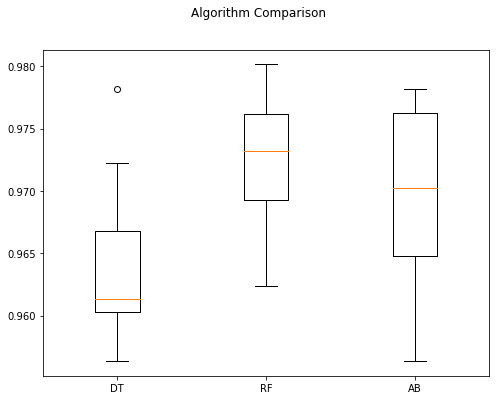

In [ ]:
compareModels(accuracies, results, classifiers)

Testing the model on Random Forest


In [ ]:
def testModelRF(model, X_validation, Y_validation):
    # make predictions on validation dataset
    Y_predictions1 = rf.predict(X_validation)
    print("Accuracy = {:.2f}".format(accuracy_score(Y_validation, Y_predictions1)))
    print('Confusion Matrix:')
    print(confusion_matrix(Y_validation, Y_predictions1))
    print('Classification Report:')
    print(classification_report(Y_validation, Y_predictions1))
    return Y_predictions1

In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        #print('Confusion matrix, without normalization')
        pass

    #print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


Train the Random Forest model and find the validation accuracy


In [ ]:
rf = RandomForestClassifier(n_estimators=10)
rf.fit(X_train, Y_train)
Y_predictions1 = testModelRF(rf, X_validation, Y_validation)

Accuracy = 0.97
Confusion Matrix:
[[663  13]
 [ 30 975]]
Classification Report:
              precision    recall  f1-score   support

      benign       0.96      0.98      0.97       676
    phishing       0.99      0.97      0.98      1005

    accuracy                           0.97      1681
   macro avg       0.97      0.98      0.97      1681
weighted avg       0.97      0.97      0.97      1681



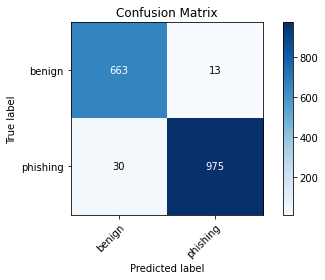

In [ ]:
# Creating the Confusion Matrix on RF model result
classes = ['benign', 'phishing']
np.set_printoptions(precision=2)
# plot non-normalized confusion matrix
plot_confusion_matrix(Y_validation, Y_predictions1, classes=classes, 
                       title='Confusion Matrix')

Testing the Decision Tree model on dataset given


In [ ]:
def testModelDT(model, X_validation, Y_validation):
    # make predictions on validation dataset
    Y_predictions2 = dt.predict(X_validation)
    print("Accuracy = {:.2f}".format(accuracy_score(Y_validation, Y_predictions2)))
    print('Confusion Matrix:')
    print(confusion_matrix(Y_validation, Y_predictions2))
    print('Classification Report:')
    print(classification_report(Y_validation, Y_predictions2))
    return Y_predictions2

Train the Decision Tree model and find the validation accuracy


In [ ]:
dt = DecisionTreeClassifier()
dt.fit(X_train, Y_train)
Y_predictions2 = testModelDT(dt, X_validation, Y_validation)

Accuracy = 0.96
Confusion Matrix:
[[639  37]
 [ 38 967]]
Classification Report:
              precision    recall  f1-score   support

      benign       0.94      0.95      0.94       676
    phishing       0.96      0.96      0.96      1005

    accuracy                           0.96      1681
   macro avg       0.95      0.95      0.95      1681
weighted avg       0.96      0.96      0.96      1681



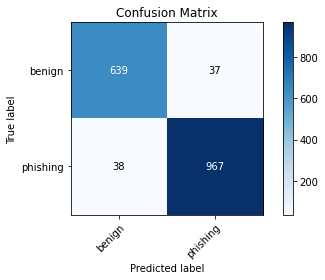

In [ ]:
# Creates confusion matrix based on DT model result
classes = ['benign', 'phishing']
np.set_printoptions(precision=2)
# plot non-normalized confusion matrix
plot_confusion_matrix(Y_validation, Y_predictions2, classes=classes, 
                       title='Confusion Matrix')